In [1]:
import torch
from dlc_practical_prologue import generate_pair_sets
import torch.nn as nn
from print_util import *
from utils import *
import time

## 1. Generate raw data, process it

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

_We normalized the data so it has mean 0 and std 1._

In [4]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

_We will create a validation set to tune hyperparameters. This validation set is created from the training set in order to have fully independent testing data._

_80% of the training data goes to training and the remaining 20% for our validation set._

In [5]:
index_permutation = torch.randperm(train_input.size(0))

validation_proportion = 0.2
split = int(0.2 * train_input.size(0))

validation_index = index_permutation[:split]
training_index = index_permutation[split:]

validation_input = train_input[validation_index]
validation_target = train_target[validation_index]
validation_classes = train_classes[validation_index]

train_input = train_input[training_index]
train_target = train_target[training_index]
train_classes = train_classes[training_index]

In [6]:
print(train_input.size(0))
print(validation_input.size(0))

800
200


## 2. Creating & Training models

In [7]:
import models
import torch.nn.functional as F

In [8]:
BATCH_SIZE = 64
architecture = models.SiameseNetwork

In [9]:
def test(test_input, test_target, test_classes, model, criterion, batch_size, aux=0.0):
    model.eval()  # Switch to eval mode in case we use an architecture that requires it
    with torch.no_grad():
        nb_final_errors = 0
        nb_digit_errors = 0
        loss_sum = 0
        
        for inputs, classes, targets in zip(test_input.split(batch_size), 
                                            test_classes.split(batch_size), 
                                            test_target.split(batch_size)):

            classes1, classes2 = classes[:, 0], classes[:, 1]
            inputs1, inputs2 = separate_channels(inputs)
            outputs1, outputs2 = model.digit_pred(inputs1), model.digit_pred(inputs2)
            loss_digit = criterion(outputs1, classes1) + criterion(outputs2, classes2)
            loss_sum += aux * loss_digit
            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)

            for k in range(len(inputs)):
                if classes1[k] != predicted1[k]:
                    nb_digit_errors += 1
                if classes2[k] != predicted2[k]:
                    nb_digit_errors += 1
            
            outputs = model(inputs)
            loss_final = criterion(outputs, targets)
            loss_sum += loss_final
            _, predicted = torch.max(outputs, 1)
            
            for k in range(len(inputs)):
                if targets[k] != predicted[k]:
                    nb_final_errors += 1

        final_acc = (1 - (nb_final_errors / test_input.size(0))) * 100
        digit_acc = (1 - (nb_digit_errors / (test_input.size(0) * 2))) * 100
        
        return final_acc, digit_acc, loss_sum.item()

In [10]:
def train_model(model, train_input, train_target, train_classes, test_input, test_target, test_classes,
                nb_epoch, batch_size, optimizer_params, logging = False, aux=0.0):
    lr, momentum, weight_decay, gamma = optimizer_params['lr'], optimizer_params['momentum'], optimizer_params['weight_decay'], optimizer_params['gamma']    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)
    criterion = nn.CrossEntropyLoss()
    
    if logging:
        log_acc_loss_header(color=Color.GREEN, aux=True)
    
        train_final_accuracies = []
        train_digit_accuracies = []
        train_losses = []
        test_final_accuracies = []
        test_digit_accuracies = []
        test_losses = []
        start_time = time.time()
    
    for e in range(nb_epoch):
        model.train()  # Switch to train mode in case we use an architecture that requires it
        for inputs, targets, classes in zip(train_input.split(batch_size),
                                            train_target.split(batch_size),
                                            train_classes.split(batch_size)):
            
            inputs1, inputs2 = separate_channels(inputs)
            outputs1, outputs2 = model.digit_pred(inputs1), model.digit_pred(inputs2)
            loss_digit = criterion(outputs1, classes[:, 0]) + criterion(outputs2, classes[:, 1])
            loss = aux * loss_digit
                
            outputs = model(inputs)
            loss_final = criterion(outputs, targets)
            loss += loss_final
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        scheduler.step()  # Update the learning rate
        
        if logging:
            train_final_acc, train_digit_acc, train_loss = test(train_input, train_target, train_classes, model, criterion, batch_size, aux=aux)
            test_final_acc, test_digit_acc, test_loss = test(test_input, test_target, test_classes, model, criterion, batch_size, aux=aux)
        
            train_final_accuracies.append(train_final_acc)
            train_digit_accuracies.append(train_digit_acc)
            train_losses.append(train_loss)
            
            test_final_accuracies.append(test_final_acc)
            test_digit_accuracies.append(test_digit_acc)
            test_losses.append(test_loss)
        
            elapsed_time = time.time() - start_time
            log_acc_loss_aux(e, nb_epoch, elapsed_time, train_loss, train_final_acc, train_digit_acc, test_loss, test_final_acc, test_digit_acc, persistent=False)
            
    if logging:
        print()
        return train_final_accuracies, train_digit_accuracies, train_losses, test_final_accuracies, test_digit_accuracies, test_losses

In [11]:
basic_model = architecture(nb_conv=3, final_bias=True)
basic_model = basic_model.to(device=device)
_, _, _, _, _, _ = train_model(basic_model, train_input, train_target, train_classes,
                   test_input, test_target, test_classes, 
                   50, BATCH_SIZE, {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0., 'gamma': 0.97},
                   logging = True, aux = 0.3)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     136s    0.0033         100.0000       100.0000            23.8280        91.8000        94.5000             


_We will now tune hyperparameters. For now, we are tuning the learning rate, the momemtum and the number of epochs._

In [12]:
run_cell = False
if run_cell:
    learning_rates = [0.001, 0.01, 0.1, 0.25, 0.5]
    momentums = [0.9] #[0.5, 0.7, 0.9]
    weight_decays = [0.0] #, 0.01, 0.1]
    nb_epoch = 50
    gammas = [0.8, 0.9, 1.0]
    auxs = [0.0, 0.1, 0.2, 0.4]

    best_accuracy = 0
    best_params = {}

    for lr in learning_rates:
        for gamma in gammas:
            for momentum in momentums:
                for weight_decay in weight_decays:

                    # creating params for optimizer
                    optimizer_params = {'lr':lr, 'momentum':momentum, 'weight_decay': weight_decay, 'gamma': gamma}

                    # initialize raw model
                    model = architecture()
                    model = model.to(device=device)

                    # train model on training data
                    train_model(model,
                                train_input,
                                train_target,
                                train_classes,
                                None,
                                None,
                                None,
                                nb_epoch, BATCH_SIZE, optimizer_params)

                    # compute accuracy on validation data
                    accuracy, loss = test(validation_input, validation_target, validation_classes, model, nn.CrossEntropyLoss(), BATCH_SIZE, aux=aux)

                    print("Lr: " + repr(lr) + " - Momentum: " + repr(momentum) + " - Weight decay: " + repr(weight_decay) +
                         " - Gamma: " + repr(gamma) + " => Accuracy: " + repr(accuracy))

                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_params['lr'] = lr
                        best_params['momentum'] = momentum
                        best_params['nb_epoch'] = nb_epoch
                        best_params['weight_decay'] = weight_decay
                        best_params['gamma'] = gamma

    print("Best accuracy obtained = {a}\n".format(a = best_accuracy))
    print("with the following hyperparameters:\n")
    print(best_params)

## NOTE: Hyperparameters tuning is not optimal yet, do not consider the above results as  good yet.

In [13]:
best_optimizer_params = {'lr': 0.1, 'momentum': 0.9, 'weight_decay': 0.0, 'gamma': 0.97}
aux = 0.2
best_nb_epoch = 50

_Now that we have the best hyperparameters let's retrained the model and visualize the evolution of accuracy and loss on both the train and test sets._

In [14]:
final_model = architecture(nb_conv=2).to(device=device)
# We regenerate data to train the model on all the training data available. 
# We don't need the validation split at this step.
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [15]:
train_accuracies, train_digit_accuracies, train_losses, \
test_accuracies, test_digit_accuracies, test_losses = train_model(final_model,
                                                                  train_input, 
                                                                  train_target, 
                                                                  train_classes, 
                                                                  test_input, 
                                                                  test_target, 
                                                                  test_classes, 
                                                                  best_nb_epoch, 
                                                                  BATCH_SIZE, 
                                                                  best_optimizer_params, 
                                                                  logging = True,
                                                                  aux=aux)

Epoch       Time    Train loss     Train acc      Train digit acc     Test loss      Test acc       Test digit acc      
[50/50]     122s    0.0047         100.0000       100.0000            18.5612        89.8000        94.8500             


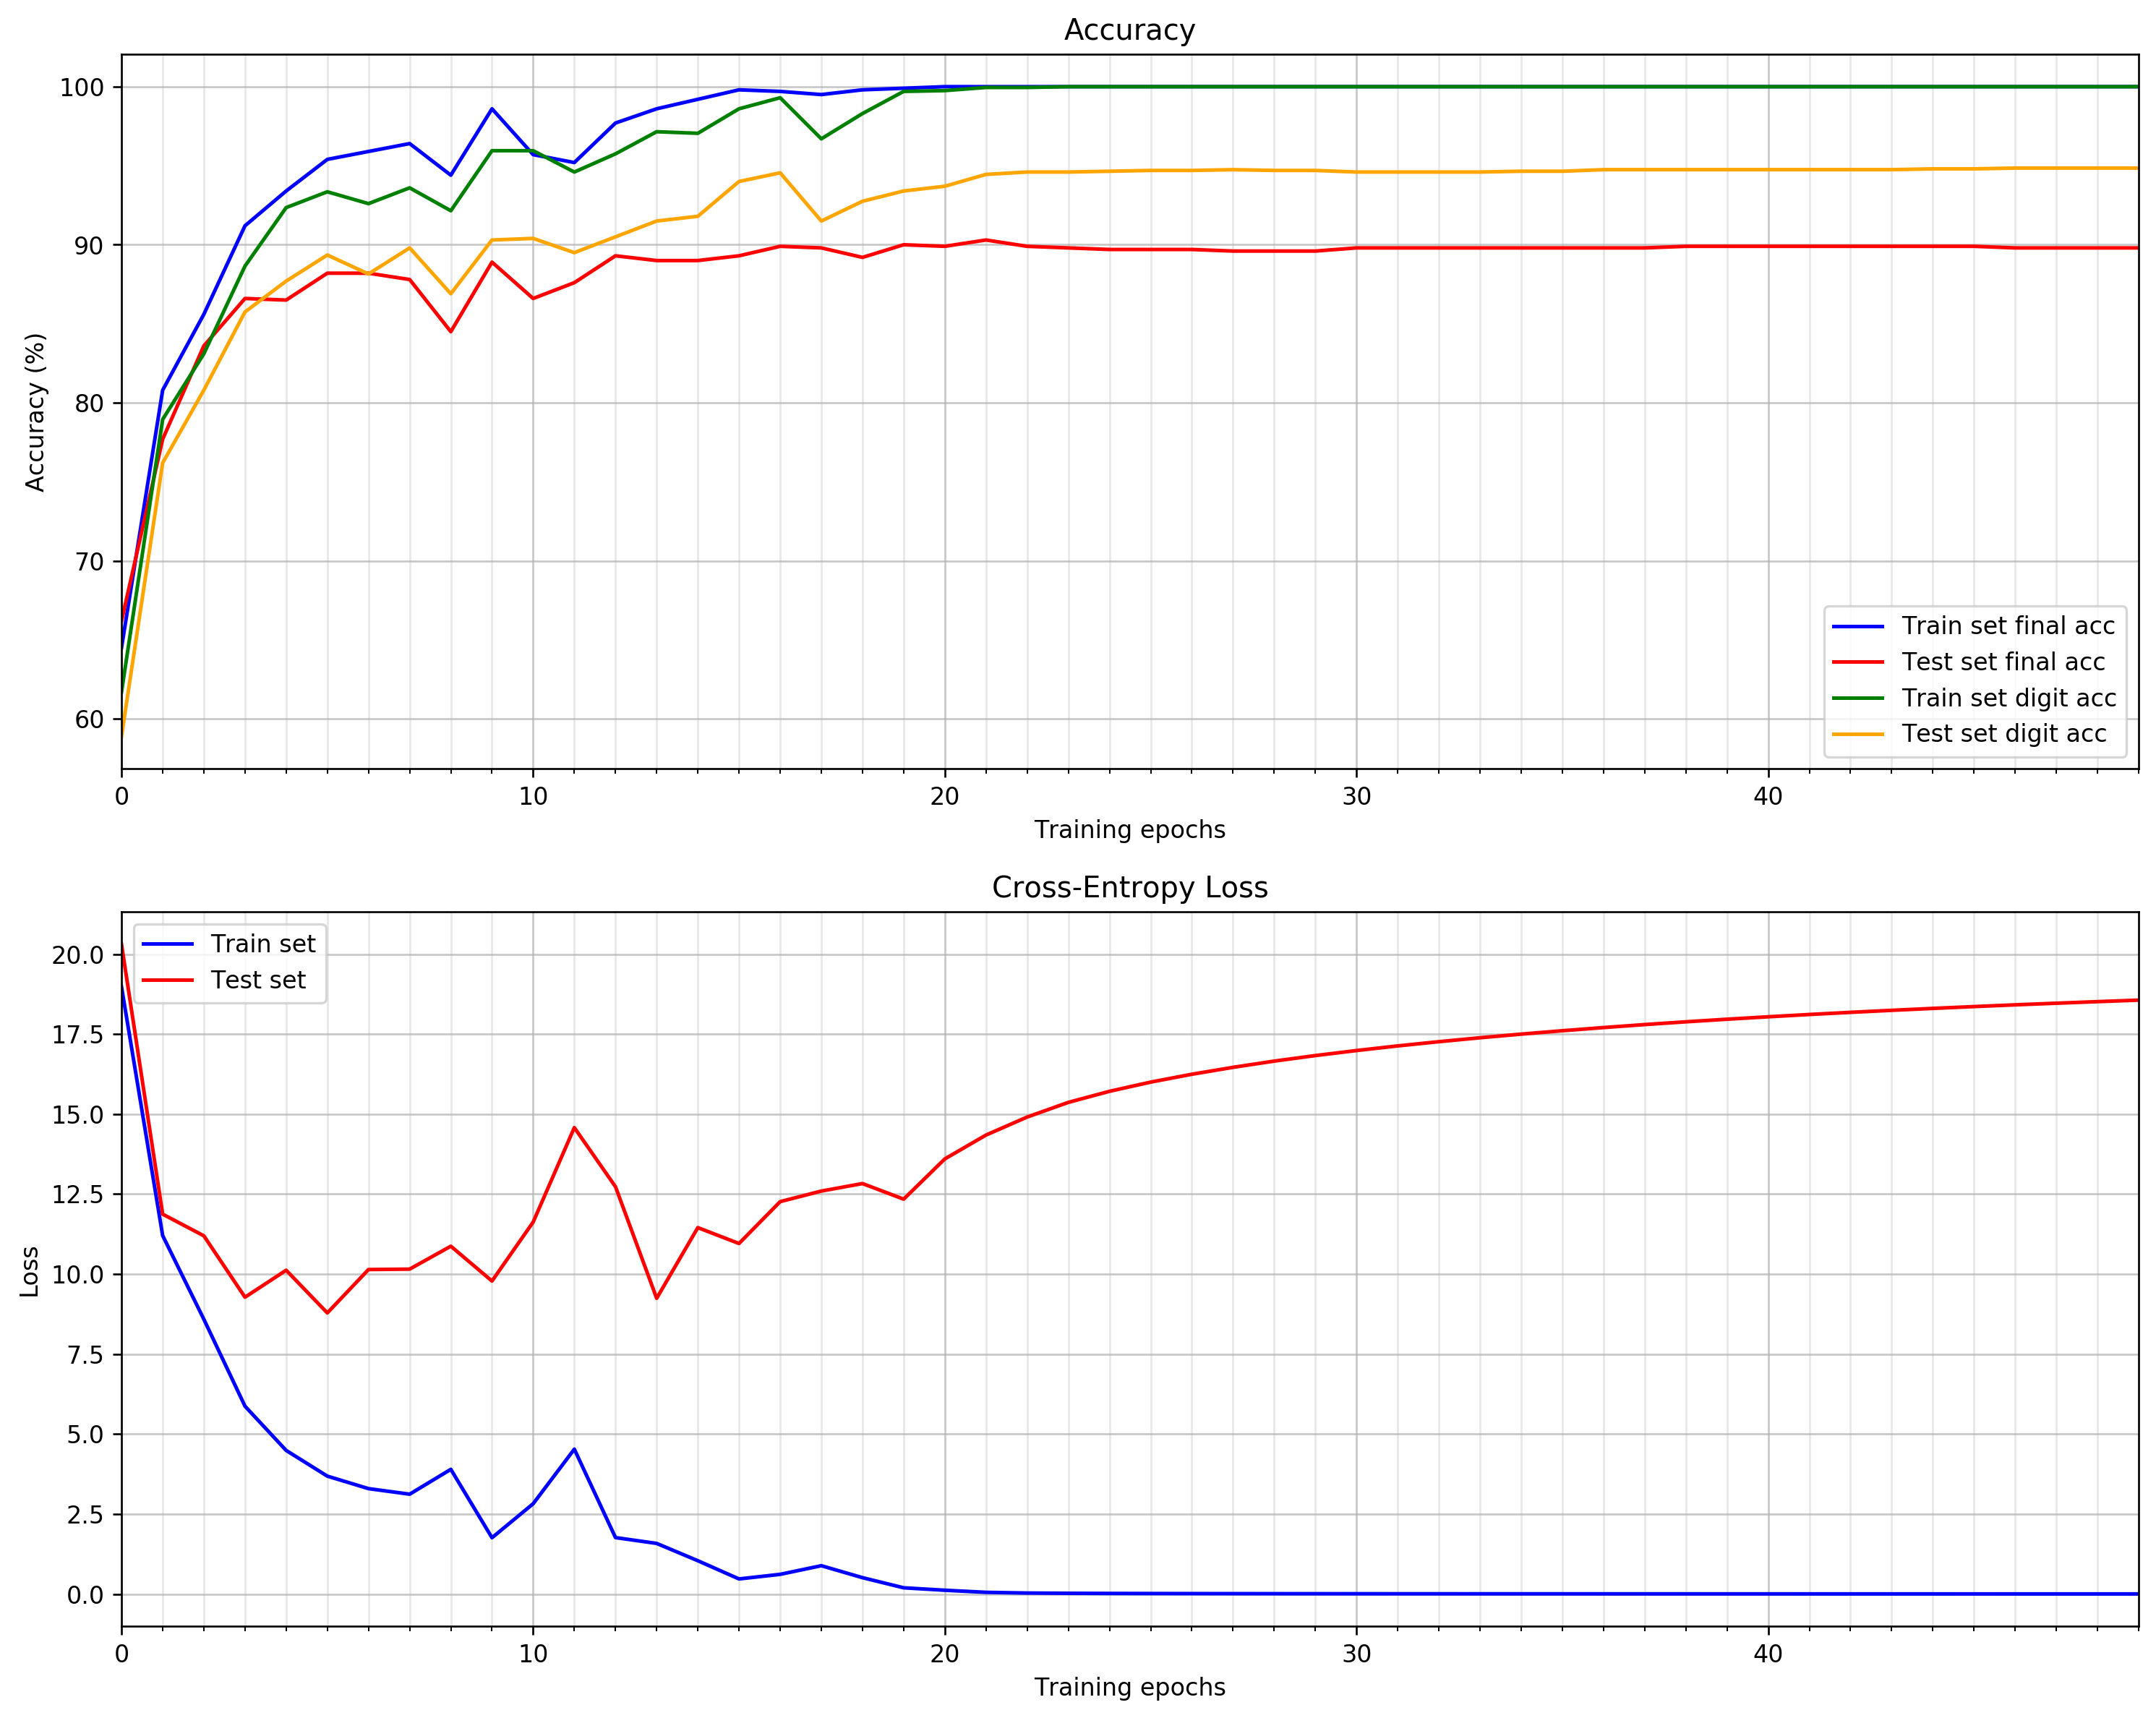

In [16]:
plot_acc_loss_aux(train_accuracies, train_digit_accuracies, train_losses, test_accuracies, test_digit_accuracies, test_losses)

## 3. Testing model

_In order to test the model we will generate new data (training and test set), retrained the model on the new data en evaluate it on the new test set. We will do this process more than 10 times and estimates the mean accuracy as well as its standard deviation._

In [17]:
def evaluate_model(model, nb_rounds, criterion):
    accuracies = []
    log_evaluate_header(color=Color.GREEN)
    
    for round in range(nb_rounds):
        # initialize new model
        model_evaluated = model(nb_conv=2, final_bias=True).to(device=device)
        # generate new data
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)
        train_input = normalize_data(train_input)
        test_input = normalize_data(test_input)
        
        train_model(model_evaluated,
                    train_input, train_target, train_classes,
                    None, None, None,
                    best_nb_epoch, BATCH_SIZE, 
                    best_optimizer_params, aux=aux)
        
        accuracy, _, loss = test(test_input, test_target, test_classes, model_evaluated, criterion, BATCH_SIZE, aux=aux)
        log_evaluate(round, nb_rounds, accuracy, loss, persistent=True)
        accuracies.append(accuracy)
        
    return torch.FloatTensor(accuracies)

In [18]:
nb_rounds = 10
accuracies = evaluate_model(architecture, nb_rounds, nn.CrossEntropyLoss())

Round       Test accuracy       Test loss      
[1/10]      90.3000             18.3377        
[2/10]      90.7000             14.8123        
[3/10]      91.0000             14.4536        
[4/10]      89.6000             27.3663        
[5/10]      90.2000             17.4935        
[6/10]      92.6000             13.5560        
[7/10]      90.4000             19.9380        
[8/10]      90.5000             23.3058        
[9/10]      91.1000             19.4665        
[10/10]     90.0000             18.3580        


In [19]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies.mean()))
print("The accuracy standard deviation is: {s:0.4f}".format(s = accuracies.std()))

The mean accuracy is: 90.64
The accuracy standard deviation is: 0.8208
